In [1]:
%config InlineBackend.figure_formats = ['svg']
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt
import json
from iminuit.util import MError, ValueView

In [2]:
from templatefitting import *
from ptbinnedfittinghelpers import *

In [3]:
lumi = 140 # fb

# Loading Data, Templates and ang coeffs

In [4]:
# # Setup
# cuts = 'cuts'
#
# pathtoptbins = 'data_ptbinned/ptbins.txt'
# pathtodata = 'data_ptbinned/histo_'+cuts
# pathtocoeffs = 'data_ptbinned/histo_nocuts'
# pathtotemplates = f'ptbinned/Zjj_ptbin_temps_{cuts}'
#
# _load = 'full'
# overflow = True
# uncertgoal = .1

In [5]:
# Setup
cuts = 'cuts'

pathtoptbins = 'data_ptbinned/ptbins.txt'
pathtodata = 'data_ptbinned/labframe/histo_'+cuts
pathtocoeffs = 'data_ptbinned/labframe/histo_nocuts'
pathtotemplates = f'templates/ptbinned/Zjj_ptbin_temps_{cuts}_lab0'

_load = 'full'
overflow = True
uncertgoal = .1

In [6]:
if overflow:
    data, data_of, temps, temps_of, ptbins, angbins, coeffs, coeffs_of = load(pathtodata, pathtotemplates, pathtoptbins, pathtocoeffs, _load, overflow)
else:
    data, temps, ptbins, angbins, coeffs = load(pathtodata, pathtotemplates, pathtoptbins, pathtocoeffs, _load, overflow)

full
loading full data from data_ptbinned/labframe/histo_cuts with 44 bins
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
xsec yvals
yvals
xsec yvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
2D zvals
zvals
2D zvals
cos yvals
cos

# Fit class and plotting functions

In [12]:
# class that handles the fitting procedure
class BinnedFits:
    """
    ptbinnedfits facilitates fitting templates with an additional pt binning. When the fitting function is called, the fitting algorithm is used to optimize the ptbinning, such that the uncertainty goal is met in each bin.
    Furthermore, this class is plottable using the plotting function defined below.
    """
    def __init__(self, data, xsec, templates, ang_bins, ptbins, coeffs=None, data_of=None, xsec_of=None, temps_of=None, coeffs_of=None, lumi=140, fitclass=TemplateFits_2d, uncertgoal=0.1):
        """
        initializes the fit object:
            - scales data to lumi
            - makes sure everything is a np.ndarray
            - handles default vals for optional args

        :param data: 2D list or numpy array of the shape (# pt bins, # angular bins) filled with the data in the form xsec / binsize. The angular bins are flattened into a 1D array.
        :type data: list[list[float]] | np.ndarray
        :param xsec: 2D list or numpy array of the shape (# pt bins, 1) filled with the xsec in each pt bin integrated over the angular variables.
        :type xsec: list[list[float]] | np.ndarray
        :param templates: 3D list or numpy array of the shape ( # pt bins, # templates, # angular bins) filled with the templates in the form xsec / binsize
        :type templates: list[list[list[float]] | np.ndarray
        :param ang_bins: 2D list with the shape of (2, # angular bins + 1) filled with bin edges of the angular variables cos theta and phi.
        :type ang_bins: list[list[float]] | np.ndarray
        :param ptbins: list with length # ptbins + 1 filled with the ptbin edges.
        :param coeffs: 2d list with shape (# ptbins, # templates). If None default coefficients will be set to 1. (default: None)
        :type coeffs: list[list[float]] | np.ndarray | None, optional
        :param data_of: in case the overflow is supposed to be fitted aswell, list with length # of angular bins filled with data from the overflow bin in the form xsec / binsize (default: None).
        :type data_of: list[float] | np.ndarray | None, optional
        :param xsec_of: in case the overflow is supposed to be fitted aswell, list of length 1 filled with xsec for overflow bin
        :type xsec_of: list[float] | np.ndarray | None, optional
        :param temps_of: in case the overflow is supposed to be fitted aswell, 2s list of shape (# templates, # angular bins) (default: None).
        :type temps_of: list[list[float]] | np.ndarray | None, optional
        :param coeffs_of: in case the overflow is supposed to be fitted aswell, list of length # of templates filled with coefficients for overflow bin (default: None).
        :type coeffs_of: list[float] | np.ndarray | None, optional
        :param lumi: integrated luminosity the pseudo data should be scaled to. default: 140 lumi_units.
        :param fitclass: class that is callable and return function to be minimized for the fitting procedure. default: TemplateFits_2d.
        :param uncertgoal: goal for relative uncertainty for template fitting. default: 0.1.
        """
        self.dx = (angbins[0][1] - angbins[0][0]) * (angbins[1][1] - angbins[1][0])             # angular bin area
        self.data = np.array(data) * lumi * self.dx                                             # data scaled to lumi shape:
        self.templates = np.array(templates)                                                    # templates not yet scaled to lumi
        self.xsec = np.array(xsec)
        self.ptbins = np.array(ptbins)
        self.fitclass = fitclass
        self.ang_bins = np.array(ang_bins)
        self.lumi = lumi
        if data_of is not None:
            self.data_of = np.array(data_of) * lumi * self.dx
        else:
            self.data_of = None

        if temps_of is not None:
            self.temps_of = np.array(temps_of)
        else:
            self.temps_of = None

        if coeffs is None:
            self.coeffs = np.ones((len(ptbins) - 1, 9))
        else:
            self.coeffs = coeffs
            for i in range (len(ptbins) - 1):
                self.coeffs[i,8] = xsec[i][0]

        if coeffs_of is None:
            self.coeffs_of = np.ones(9)
        else:
            self.coeffs_of = coeffs_of
            self.coeffs_of[8] = xsec_of[0]

        self.uncertgoal = uncertgoal
        self.datashape = (int(np.sqrt(len(self.data[0,:]))), int(np.sqrt(len(self.data[0,:]))))

    def fitting(self):
        """
        facilitates fitting the templates and the bin optimization
        algorithm:
            - starts fitting in last bin
            - checks if fit converges and uncertainty goal is achieved
            - if not merges with next pt bin iteratively until fit converges and uncertainty goal is achieved
        """
        self.fitparams = []
        self.fiterrors = []
        self.fitptbins = [self.ptbins[-1]]
        self.minuit = []
        i = 0
        n = len(self.ptbins)
        rebin = False

        # loop over all pt bins
        while i < n - 1:
            # initial fitting try
            data = self.data[-1-i]
            temps = self.templates[-1-i]
            coeffs = self.coeffs[-1-i,:] / np.append(np.ones(8), (self.ptbins[n-1-i] - self.ptbins[n-i-2]))             # avg of first coeffs (0-7); A_8 = xsec --> avg and normalized to fb / GeV
            # print('dat: ', data)
            # print('temps: ', temps)
            # print(coeffs)
            m = self.fit_helper(data, temps, coeffs)
            # print('dat: ', data)
            # print('temps: ', temps)
            j = 0

            # loop unti
            while m == -1 and i+j+1 < n - 1:
                j += 1
                print("first loop j: ", j)
                data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                # print("SUMTS: ", np.sum(temps.T, axis=1))
                # print("DATA: ", data)
                print("ptbin verifying")
                # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                print(coeffs)
                # print(data.shape, temps.shape)
                m = self.fit_helper(data, temps, coeffs)
            if m == -1:
                print("------------------------------------------------------------------")
                print("rebinning cos")
                print("------------------------------------------------------------------")
                rebin = True
                j = 0
                while m == -1 and i+j < n - 1:

                    print("rebin j: ", j)
                    data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                    temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                    data, temps = self.rebin(data, temps)
                    # print("SUMTS1: ", np.sum(temps.T, axis=1))
                    # print("DATA1: ", data)
                    print("ptbin verifying")
                    # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                    print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                    coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                    print(coeffs)
                    # print(data.shape, temps.shape)
                    m = self.fit_helper(data, temps, coeffs)
                    j += 1
            if m == -1:
                print("i: ", i,", j: ", j,  "n-1: ", n-1, i+j+1)
                raise Exception("skdlflksjflksdf")

            # print(i+j+1 < n - 1)
            # print(i, j, n)
            # print(m)
            while (m.merrors['x0'].upper / m.values['x0'] > self.uncertgoal or m.merrors['x0'].lower / m.values['x0'] > self.uncertgoal) and i+j+1 < len(self.ptbins) - 1:
                print(f"Merrors > {self.uncertgoal * 100:.2f}%: {m.merrors['x0'].upper / m.values['x0']}, {m.merrors['x0'].lower / m.values['x0']} in bin [{self.ptbins[n-i-j-2]}, {self.ptbins[n-1-i]}]")
                j += 1
                print("last loop j: ", j)
                data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                if rebin:
                    data, temps = self.rebin(data, temps)
                # print(np.sum(temps.T, axis=1))
                # print("ptbin verifying")
                # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                print(coeffs)
                # print(data.shape, temps.shape)
                m = self.fit_helper(data, temps, coeffs)
            self.minuit.append(m)
            self.fitparams.insert(0, m.values)
            self.fiterrors.insert(0, m.merrors)
            self.fitptbins.insert(0, self.ptbins[n-i-j-2])
            print(f"reached precision in bin: [{ptbins[n-i-j-2]}, {self.ptbins[n-1-i]}")
            print(m)
            print("---------------------------------------------------------")
            i += j + 1
            print("i: ", i)

        if self.data_of is not None and self.temps_of is not None:
            print("fitting overflow")
            m = self.fit_helper(self.data_of, self.temps_of, self.coeffs_of * np.append(np.ones(8), 1 / (1000 - ptbins[-1])))
            self.fitparams_of = m.values
            self.fiterrors_of = m.merrors



        # if sum(mergelist) != len(self.ptbins) - 1:
        #     raise Exception("mergelist passt nicht")
        # rebin(mergelist)

    def rebin(self, data, temps):

        newdata = self.rebin_cos_data(data)
        newtemps = []
        for i in range(9):
            t = newtemps.append(self.rebin_cos_data(temps[i,:]))

        return newdata, np.array(newtemps)


    def rebin_cos_data(self, data):
        d = data.reshape(self.datashape)
        temp = np.zeros((self.datashape[0]-2, self.datashape[1]))
        i = 0
        temp[i,:] = np.sum(d[i:i+2,:], axis=0)
        for i in range(1, self.datashape[0]-3):
            temp[i,:] = d[i+1,:]
        i = self.datashape[0]-3
        temp[i, :] = np.sum(d[i+1:,:], axis=0)
        # self.datashape = (temp.shape)
        return temp.flatten()


    def rebin_cos_template(self, templates):
        for i in range(9):
            templates = self.rebin_cos_data( templates[i,:] )

    def fit_helper(self, data, templates, coeffs):
        print("Temphape: ",templates.shape)
        print("datashape: ", data.shape)
        m = Minuit(self.fitclass(self.dx, templates.T, data, coeffs, self.lumi), coeffs)
        # m.fixed[3] = True
        m.migrad()
        try:
            m.minos()
        except RuntimeError:
            print(f"No valid minimum found")
            return -1
        return m


def plotting(fitobj, plotselect='full', kwargs=None, figsavekwargs=None, figsize=(15,15)):
    with plt.rc_context({
    'font.size': 12,  # Base font size
    'axes.labelsize': 12,  # Axis label font size
    'axes.titlesize': 14,  # Title font size
    'xtick.labelsize': 10,  # X-tick label font size
    'ytick.labelsize': 10,  # Y-tick label font size
    'legend.fontsize': 10  # Legend font size
    }):
        if kwargs is None:
            kwargs = {"fmt": "o", "ms": 5, "capsize": 6}
        if figsavekwargs is None:
            figsavekwargs = dict(dpi=300, transparent=False)
        pt, ptxerr = plotpt(fitobj)
        y = np.array(fitobj.fitparams)
        ylo, yup = fitobj.plotyerr(fitobj)
        if plotselect == 'full':
            if fitobj.fitparams_of is None:
                fig, ax = plt.subplots(9, 1, figsize=figsize)
                for i in range(9):
                    ax[i].set_xlim(20, 200)
                    ax[i].set_xlabel('$p_T$ / [GeV]')
                    ax[i].set_ylabel(f'$A_{i}$')
                    ax[i].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
            else:
                fig = plt.figure(figsize=figsize, constrained_layout=False)
                ax = [[0 for l in range(2)] for k in range(9)]
                gs = fig.add_gridspec(9, 6, wspace=0.05, hspace=0.3)
                for i in range(9):
                    ax[i][0] = fig.add_subplot(gs[i,:-1])
                    ax[i][1] = fig.add_subplot(gs[i,-1])
                # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                ax = np.array(ax)
                for i in range(9):
                    print(i)
                    ax[i, 0].sharey(ax[i, 1])
                    ax[i, 0].set_xlim(min(fitobj.ptbins) - 10, max(fitobj.ptbins) + 10)
                    # print(ax.shape)
                    ax[i, 0].set_ylabel(f'$A_{i}$')
                    if i == 8:
                        ax[i, 0].set_yscale('log')
                        ax[i, 0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                        ax[i, 0].set_xlabel('$p_T^{\mathrm{Z}}$ [GeV]')
                    x = np.linspace(20,200)
                    yp = x*0.1
                    # ax[i, 0].plot(x, yp)
                    # print("bins: ",pt)
                    # print("y: ", y[i])
                    # print(y[:i].shape)
                    # ax[i, 0].errorbar(x, yp, xerr=0.1*x, yerr=np.sqrt(yp), **kwargs)
                    ax[i, 0].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                    ax[i, 1].set_xlim(0, 1)
                    ax[i, 1].set_xticks([0.5])
                    ax[i, 1].set_xticklabels(["overflow"])
                    try:
                        ax[i, 1].errorbar(0.5 , fitobj.fitparams_of[i], yerr=[[abs(fitobj.fiterrors_of[f"x{i}"].lower)], [fitobj.fiterrors_of[f"x{i}"].upper]], **kwargs)
                    except KeyError:
                        ax[i, 1].errorbar(0.5 , fitobj.fitparams_of[i], yerr=0.00001, **kwargs)
                    # hide the spines between ax and ax2
                    ax[i, 0].spines['right'].set_visible(False)
                    ax[i, 1].spines['left'].set_visible(False)
                    ax[i, 0].yaxis.tick_left()
                    # ax[i, 0].tick_params(labelright='off')
                    ax[i, 1].tick_params(labelleft='off')
                    ax[i, 1].yaxis.tick_right()

                    # This looks pretty good, and was fairly painless, but you can get that
                    # cut-out diagonal lines look with just a bit more work. The important
                    # thing to know here is that in axes coordinates, which are always
                    # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                    # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                    # appropriate corners of each of our axes, and so long as we use the
                    # right transform and disable clipping.

                    d = .01  # how big to make the diagonal lines in axes coordinates
                    # arguments to pass plot, just so we don't keep repeating them
                    anzdia=int(9)
                    kwargs1 = dict(transform=ax[i, 0].transAxes, color='k', clip_on=False)
                    ax[i, 0].plot((1-d, 1+d), (-d*anzdia, +d*anzdia), **kwargs1)
                    ax[i, 0].plot((1-d, 1+d), (1-d*anzdia, 1+d*anzdia), **kwargs1)

                    kwargs1.update(transform=ax[i, 1].transAxes)  # switch to the bottom axes
                    ax[i, 1].plot((-d*5, +d*5), (1-d*anzdia, 1+d*anzdia), **kwargs1)
                    ax[i, 1].plot((-d*5, +d*5), (-d*anzdia, +d*anzdia), **kwargs1)

                fig.savefig(f'ptbinned-fits-full_{cuts}.png', **figsavekwargs)
                print(f"saved as: ptbinned-fits-full_{cuts}.png")

        elif is_iterable(plotselect):
            if fitobj.fitparams_of is None:
                fig, ax = plt.subplots(len(plotselect), 1, figsize=figsize)
                for j, i in enumerate(plotselect):
                    i =  int(i)
                    ax[j].set_xlim(20, 200)
                    ax[j].set_xlabel('$p_T$ / [GeV]')
                    ax[j].set_ylabel(f'$A_{i}$')
                    ax[j].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
            else:
                fig = plt.figure(figsize=figsize, constrained_layout=False)
                ax = [[0 for l in range(2)] for k in range(len(plotselect))]
                gs = fig.add_gridspec(len(plotselect), 6, wspace=0.05, hspace=0.2)
                for i in range(len(plotselect)):
                    ax[i][0] = fig.add_subplot(gs[i,:-1])
                    ax[i][1] = fig.add_subplot(gs[i,-1])
                # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                ax = np.array(ax)
                for j, i in enumerate(plotselect):
                    print(j)
                    ax[j, 0].sharey(ax[j, 1])
                    ax[j, 0].set_xlim(min(fitobj.ptbins)-10, max(fitobj.ptbins) + 10)
                    # print(ax.shape)
                    ax[j, 0].set_ylabel(f'$A_{i}$')
                    if i == 8:
                        ax[j, 0].set_yscale('log')
                        ax[j, 0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                    # x = np.linspace(20,200)
                    # yp = x*0.1
                    # ax[j, 0].plot(x, yp)
                    # print("bins: ",pt)
                    # print("y: ", y[i])
                    # print(y[:i].shape)
                    # ax[j, 0].errorbar(x, yp, xerr=0.1*x, yerr=np.sqrt(yp), **kwargs)
                    ax[j, 0].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                    ax[j, 1].set_xlim(0, 1)
                    ax[j, 1].set_xticks([0.5])
                    ax[j, 1].set_xticklabels(["overflow"])
                    ax[j, 1].errorbar(0.5 , fitobj.fitparams_of[i], yerr=[[abs(fitobj.fiterrors_of[i].lower)], [fitobj.fiterrors_of[i].upper]], **kwargs)

                    # hide the spines between ax and ax2
                    ax[j, 0].spines['right'].set_visible(False)
                    ax[j, 1].spines['left'].set_visible(False)
                    ax[j, 0].yaxis.tick_left()
                    # ax[j, 0].tick_params(labelright='off')
                    ax[j, 1].tick_params(labelleft='off')
                    ax[j, 1].yaxis.tick_right()

                    # This looks pretty good, and was fairly painless, but you can get that
                    # cut-out diagonal lines look with just a bit more work. The important
                    # thing to know here is that in axes coordinates, which are always
                    # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                    # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                    # appropriate corners of each of our axes, and so long as we use the
                    # right transform and disable clipping.

                    d = .01  # how big to make the diagonal lines in axes coordinates
                    # arguments to pass plot, just so we don't keep repeating them
                    anzdia=int(len(plotselect))
                    kwargs1 = dict(transform=ax[j, 0].transAxes, color='k', clip_on=False)
                    ax[j, 0].plot((1-d, 1+d), (-d*anzdia, +d*anzdia), **kwargs1)
                    ax[j, 0].plot((1-d, 1+d), (1-d*anzdia, 1+d*anzdia), **kwargs1)

                    kwargs1.update(transform=ax[j, 1].transAxes)  # switch to the bottom axes
                    ax[j, 1].plot((-d*5, +d*5), (1-d*anzdia, 1+d*anzdia), **kwargs1)
                    ax[j, 1].plot((-d*5, +d*5), (-d*anzdia, +d*anzdia), **kwargs1)
                    savename = ''
                    for i in plotselect:
                        savename += f'A_{i}+'
                fig.savefig(f'ptbinned-fits-{savename[:-1]}_{cuts}.png', **figsavekwargs)
                print(f"saved as: ptbinned-fits-{savename[:-1]}_{cuts}.png")


        elif isinstance(plotselect, int):
            if fitobj.fitparams_of is None:
                fig, ax = plt.subplots(figsize=figsize)
                i = plotselect
                ax[0].set_xlim(min(fitobj.ptbins), max(fitobj.ptbins))
                ax.set_xlabel('$p_T$ / [GeV]')
                ax.set_ylabel(f'$A_{i}$')
                ax.errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
            else:
                fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [5,1], 'wspace': 0.02}, figsize=figsize, sharey=True)
                i = plotselect
                ax[0].set_xlim(min(fitobj.ptbins)-10, max(fitobj.ptbins) + 10)
                # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                ax[0].set_xlabel('$p_T$ / [GeV]')
                ax[0].set_ylabel(f'$A_{i}$')
                if i == 8:
                    ax[0].set_yscale('log')
                    ax[0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                ax[0].errorbar(pt, y[:,i]/2, xerr=ptxerr, yerr=[ylo[i]/2, yup[i]/2], **kwargs)
                ax[1].set_xlim(0, 1)
                ax[1].set_xticks([0.5])
                ax[1].set_xticklabels(["overflow"])
                ax[1].errorbar(0.5 , fitobj.fitparams_of[i]/2, yerr=[[abs(fitobj.fiterrors_of[i].lower) /2 ], [fitobj.fiterrors_of[i].upper / 2]], **kwargs)

                # hide the spines between ax and ax2
                ax[0].spines['right'].set_visible(False)
                ax[1].spines['left'].set_visible(False)
                ax[0].yaxis.tick_left()
                # ax[0].tick_params(labelright='off')
                ax[1].tick_params(labelleft='off')
                ax[1].yaxis.tick_right()

                # This looks pretty good, and was fairly painless, but you can get that
                # cut-out diagonal lines look with just a bit more work. The important
                # thing to know here is that in axes coordinates, which are always
                # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                # appropriate corners of each of our axes, and so long as we use the
                # right transform and disable clipping.

                d = .01  # how big to make the diagonal lines in axes coordinates
                # arguments to pass plot, just so we don't keep repeating them
                kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)

                ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
                ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

                kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
                ax[1].plot((-d*5, +d*5), (1-d, 1+d), **kwargs)
                ax[1].plot((-d*5, +d*5), (-d, +d), **kwargs)

                fig.savefig(f'ptbinned-fits-A_{plotselect}_{cuts}_pres.png', **figsavekwargs)
                print(f"saved as: ptbinned-fits-A_{plotselect}_{cuts}_pres.png")

        else:
            raise NotImplementedError("Not yet implemented.")


    plt.show()
    return fig, ax


def plotpt(fitobj):
    pt = []
    ptxerr = []

    for i in range(len(fitobj.fitptbins)-1):
        pt.append((fitobj.fitptbins[i] + fitobj.fitptbins[i+1]) / 2)
        ptxerr.append((fitobj.fitptbins[i+1] - fitobj.fitptbins[i]) / 2)
    return np.array(pt), np.array(ptxerr)

def plotyerr(fitobj):
    ylo = []
    yup = []
    for i in range(9):
        ylo.append([])
        yup.append([])
        for j in range(len(fitobj.fiterrors)):
            try:
                ylo[i].append(abs(fitobj.fiterrors[j][f"x{i}"].lower))
                yup[i].append(fitobj.fiterrors[j][f"x{i}"].upper)
            except KeyError:
                ylo[i].append(0.00001)
                yup[i].append(0.00001)
    return np.array(ylo), np.array(yup)

class FitClassJSONEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        # print(obj)
        # print(type(obj))
        # try:
        #     print(obj.__name__)
        # except AttributeError:
        #     pass
        # print()
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, ( np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)):
            return None

        elif isinstance(obj, MError):
            d = {}
            for k in obj.__slots__:
                d[k] = obj.__getattribute__(k)
            return d

        elif isinstance(obj, ValueView):
            return obj.to_dict()

        elif callable(obj) or isinstance(obj, Minuit):
            return None

        return json.JSONEncoder.default(self, obj)

In [13]:
if overflow:
    p = BinnedFits(data['2D'], data['xsec'],temps['2D'], angbins, ptbins, coeffs, data_of['2D'], data_of["xsec"], temps_of['2D'], coeffs_of, uncertgoal=uncertgoal)
else:
    p = BinnedFits(data['2D'], data['xsec'], temps['2D'], angbins, ptbins, coeffs, uncertgoal=uncertgoal)

In [14]:
p.fitting()
with open("ptbinned-fits.json", "w") as f:
    json.dump(vars(p), f, indent=4, cls=FitClassJSONEncoder)

Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 3.977202524896835, -3.846954740117811 in bin [375.0, 400.0]
last loop j:  1
[ 2.  2.  2.  2.  2.  2.  2.  2. 50.]
[ 0.06876772 -0.14377768  0.02071186 -0.12003478  0.0770465   0.01651285
 -0.03546799 -0.03853843  0.01664702]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 4.4708738474319, -4.36195116014317 in bin [350.0, 400.0]
last loop j:  2
[ 3.  3.  3.  3.  3.  3.  3.  3. 75.]
[ 0.02799448 -0.09639063  0.03893629 -0.12187681  0.08859888  0.03690658
 -0.01055643 -0.05858995  0.01897776]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 10.317153470342387, -9.896728267887509 in bin [325.0, 400.0]
last loop j:  3
[  4.   4.   4.   4.   4.   4.   4.   4. 100.]
[-0.00503474 -0.1019969   0.03834699 -0.12284236  0.05989633  0.03230502
 -0.02016237 -0.04556783  0.02116336]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: -7.183032289846878, 7.097058012566663 in bin [300.0, 400.0]
last loop j:  4
[  5.   5.   5.   5.  

0
1
2
3
4
5
6
7
8
saved as: ptbinned-fits-full_cuts.png


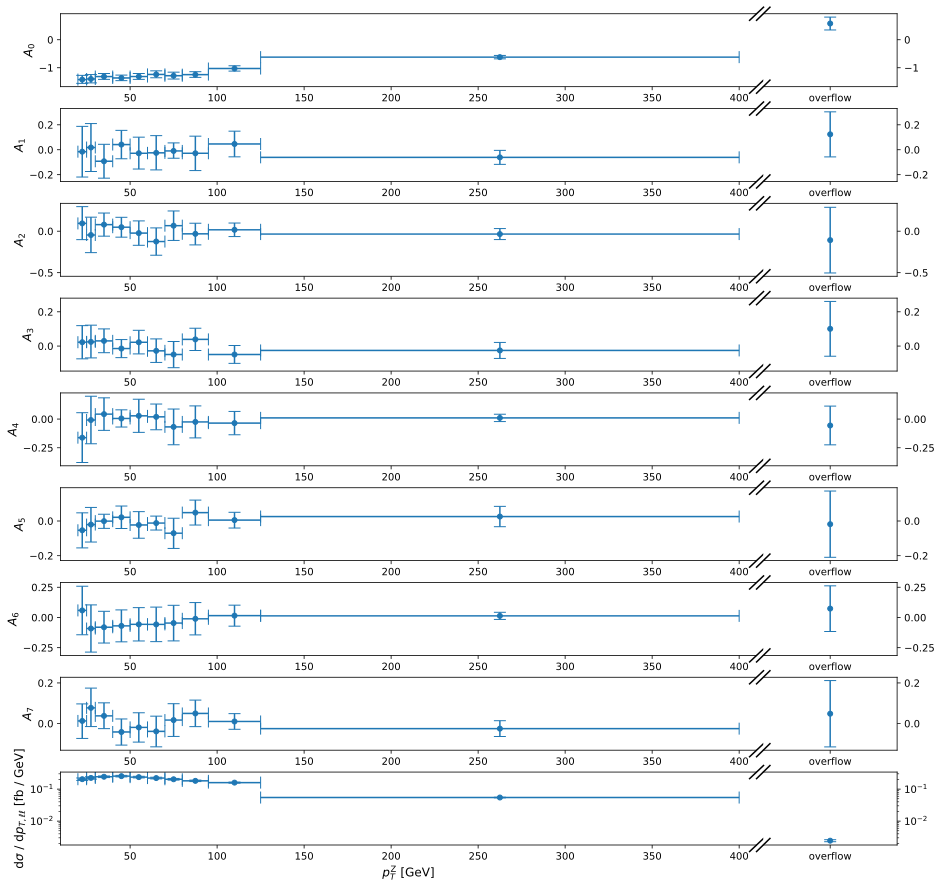

(<Figure size 1500x1500 with 18 Axes>,
 array([[<Axes: ylabel='$A_0$'>, <Axes: >],
        [<Axes: ylabel='$A_1$'>, <Axes: >],
        [<Axes: ylabel='$A_2$'>, <Axes: >],
        [<Axes: ylabel='$A_3$'>, <Axes: >],
        [<Axes: ylabel='$A_4$'>, <Axes: >],
        [<Axes: ylabel='$A_5$'>, <Axes: >],
        [<Axes: ylabel='$A_6$'>, <Axes: >],
        [<Axes: ylabel='$A_7$'>, <Axes: >],
        [<Axes: xlabel='$p_T^{\\mathrm{Z}}$ [GeV]', ylabel='d$\\sigma$ / d$p_{T,\\ell\\ell}$ [fb / GeV]'>,
         <Axes: >]], dtype=object))

In [22]:
fig, ax = p.plotting()

In [53]:
coeffs_of.shape

(9,)

In [8]:
# test if data and temps coincide
x = angbins[0]
dat = np.array(data['cos'] )
tem = np.array(temps['cos'])
temp = np.sum(tem, axis=(0,1))
dats = np.sum(dat, axis=0)

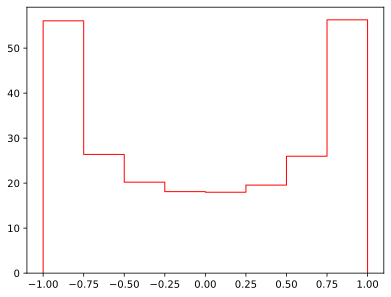

In [10]:
fig, ax = plt.subplots()
ax.stairs(dats, x, color='r')
# ax.stairs(temp, x)
plt.show()

In [31]:
p.data.shape

(44, 64)

In [15]:
fig, ax = p.plotting()

AttributeError: 'ptbinnedfits' object has no attribute 'fitparams_of'

In [48]:
ax[0].set_ylabel('$f_L^Z$')
# fig.set_size_inches(16, 8)
plt.draw()
figsavekwargs = dict(dpi=300, transparent=True)
fig.savefig(f'ptbinned_fit_lpol_{cuts}.png', **figsavekwargs)

<Figure size 640x480 with 0 Axes>

In [22]:
bins = np.array([20,30,45,70,100,140,200,275,400,550,1050])
xsec_p = np.array( [ 210,190,180,130,150,110,59,31,8.8,1.4 ] ) / 1000
delta = np.array( [ 21,20,18,17,12,12,15,13,20,25  ] )
y_min = xsec_p - xsec_p * delta / 100
y_max = xsec_p + xsec_p * delta / 100
x = []
dx = []
dy = xsec_p * delta / 100
print(dy)
for i in range(len(bins) - 1):
    x.append((bins[i+1] + bins[i]) / 2)
    dx.append((bins[i+1] - bins[i]) / 2)
ax[8,0].errorbar(x, xsec_p, xerr=dx, yerr=dy, fmt='.k', label='PAPER')
ax[8,0].stairs(y_max, bins, baseline=y_min, color='b', fill=True, label='stat. uncert', alpha=0.5)
plt.draw()
fig.savefig("temp.png")

[0.0441  0.038   0.0324  0.0221  0.018   0.0132  0.00885 0.00403 0.00176
 0.00035]


<Figure size 640x480 with 0 Axes>

In [67]:
for i in range(len(p.fitptbins)):
    print(f"{p.fitptbins[i]:.0f}", end=', ')

20, 45, 70, 100, 160, 400, 

In [95]:
print(np.sum(p.templates[0, :], axis=0))
print(p.data[0,:])

[0.         0.01267304 0.00633651 0.         0.         0.01267303
 0.01267303 0.         0.05069211 0.05702866 0.04435561 0.08237461
 0.06336517 0.05702863 0.07004708 0.03801909 0.12039377 0.13306686
 0.12673029 0.10138413 0.14573985 0.13940333 0.08871119 0.1395985
 0.16474935 0.13940339 0.13306682 0.14573964 0.08871122 0.08486417
 0.15207638 0.17742245 0.1837589  0.10138426 0.16474944 0.11168746
 0.17108591 0.0950477  0.18375896 0.14573985 0.08237469 0.10772077
 0.11405727 0.1710857  0.07603818 0.10138425 0.13306682 0.10138427
 0.0443556  0.11405731 0.06336514 0.10138411 0.10138425 0.05702861
 0.03801909 0.03168258 0.         0.         0.01267303 0.
 0.         0.         0.00633651 0.        ]
[0.         0.3483682  0.17418412 0.         0.         0.34836811
 0.34836811 0.         1.39347222 1.5676564  1.21928845 2.26438989
 1.74184124 1.567656   1.92551989 1.04510447 3.3094964  3.65786586
 3.48368109 2.78694216 4.00623402 3.83205018 2.43857662 3.83741358
 4.5287844  3.83205115 3.

In [ ]:
cos = np.linspace(-1, 1, 8)
phi = np.linspace(0, 2*np.pi, 8)
n = len(p.data[:,0])
fig,ax = plt.subplots(n, figsize=(5,5*n))
for i in range(n):
    d = p.data[i, :].reshape((8,8))
    mesh = ax[i].pcolormesh(cos, phi, d)
    ax[i].set_title(f"datbin{i}")
    fig.colorbar(mesh, ax=ax[i])
plt.show()


In [ ]:
def diffcross_costheta(norm, cos_theta, A):
    p0 = A[0]/2 * (1 - 3 * cos_theta**2)
    p4 = A[4] * cos_theta
    p8 = 1 + cos_theta**2
    p = norm * np.array([p0, p4, p8])
    return 3 * np.sum(p, axis=0) / 8
fig, ax = plt.subplots(figsize=(8,8))
x = np.linspace(-1, 1, 9)
y = diffcross_costheta(p.fitparams_of[-1], x, p.fitparams_of)
coefflo = []
coeffup = []
for i in range(len(p.fitparams_of)):
    coefflo.append(p.fitparams_of[i] + p.fiterrors_of[i].lower)
    coeffup.append(p.fitparams_of[i] + p.fiterrors_of[i].upper)
ymin = np.sum(np.array(coefflo) * np.array(p.temps_of).T, axis=0)
ymax = np.sum(np.array(coeffup) * np.array(p.temps_of).T, axis=0)

# ax.stairs( ymax[:-1], x, baseline=ymin[:-1], fill=True)
ax.stairs( data_of["cos"], x)

In [ ]:
data_of["cos"]

In [ ]:
p.coeffs[:, 8]

In [ ]:
np.sum(data_of["cos"]) * 0.25 * lumi

In [ ]:
np.array(temps["2D"]).shape

In [ ]:
p.fiterrors_of[8].lower/p.fitparams_of[8]

In [ ]:
len(p.templates[0,0, :])

In [ ]:
p.templates.shape

In [ ]:
np.sum(t) * p.dx

In [ ]:
np.array(temps_of["2D"]).shape

In [ ]:
print(temps_of["2D"])

In [ ]:
a = np.zeros((9,9))
b = []
for i in range(9):
    for j in range(9):
        a[i][j] = i+j
for i in range(8):
    b.append(i)
a = np.array(a); b = np.array(b)

In [ ]:
i=2; j=3
n = len(a)
print(a[n-i-j-2], a[n-1-i])
print(b[n-i-j-2:n-i-1])
print(np.sum(a[n-i-j-2:n-i-1], axis=0) / np.append(np.ones(8) * (j + 1), 1))

In [ ]:
b[0:2]

In [ ]:
print(" ", b)

In [24]:
p.data[2].reshape(8,8)

array([[0.        , 1.21928876, 0.17418412, 0.        , 0.        ,
        0.52255223, 0.69673636, 0.        ],
       [1.0451042 , 2.63368134, 3.83205018, 0.87091923, 1.04510447,
        3.1353134 , 2.09020893, 0.87092034],
       [2.9611288 , 3.1353142 , 4.00623402, 3.30949303, 5.05133849,
        3.1353134 , 3.65786493, 3.48368109],
       [6.7931766 , 4.00623504, 4.18041786, 3.48367665, 4.18041786,
        4.00623402, 5.57389002, 4.87715464],
       [4.3546006 , 4.35460282, 4.7029694 , 4.52877979, 4.52878555,
        4.18041786, 5.39970618, 5.39970618],
       [3.3094964 , 3.30949809, 4.52878555, 3.65786027, 3.65786493,
        2.85275973, 4.18041786, 3.65786493],
       [0.69673618, 2.61276113, 2.26439278, 0.69673547, 0.69673636,
        2.26439278, 2.26439278, 0.52255223],
       [0.        , 0.17418417, 0.34836811, 0.        , 0.        ,
        0.        , 0.34836811, 0.        ]])

In [76]:
a = dict(p.fiterrors[0])

In [85]:
for k in a.keys():
    print(k, a[k].__slots__)

x0 ('number', 'name', 'lower', 'upper', 'is_valid', 'lower_valid', 'upper_valid', 'at_lower_limit', 'at_upper_limit', 'at_lower_max_fcn', 'at_upper_max_fcn', 'lower_new_min', 'upper_new_min', 'nfcn', 'min')
x1 ('number', 'name', 'lower', 'upper', 'is_valid', 'lower_valid', 'upper_valid', 'at_lower_limit', 'at_upper_limit', 'at_lower_max_fcn', 'at_upper_max_fcn', 'lower_new_min', 'upper_new_min', 'nfcn', 'min')
x2 ('number', 'name', 'lower', 'upper', 'is_valid', 'lower_valid', 'upper_valid', 'at_lower_limit', 'at_upper_limit', 'at_lower_max_fcn', 'at_upper_max_fcn', 'lower_new_min', 'upper_new_min', 'nfcn', 'min')
x3 ('number', 'name', 'lower', 'upper', 'is_valid', 'lower_valid', 'upper_valid', 'at_lower_limit', 'at_upper_limit', 'at_lower_max_fcn', 'at_upper_max_fcn', 'lower_new_min', 'upper_new_min', 'nfcn', 'min')
x4 ('number', 'name', 'lower', 'upper', 'is_valid', 'lower_valid', 'upper_valid', 'at_lower_limit', 'at_upper_limit', 'at_lower_max_fcn', 'at_upper_max_fcn', 'lower_new_min

In [94]:
type(p.fiterrors[0][0])

iminuit.util.MError

In [89]:
dir(p.fiterrors[0])

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_repr_html_',
 '_repr_pretty_',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [174]:
def create_dict_from_merror(merrors):
    print("was called")
    d = {}
    # for m in merrors:
    #     d[m] = {}
    for k in merrors.__slots__:
        d[k] = merrors.__getattribute__(k)

    return d




In [167]:
def recursive_typer(d):
    print(type(d))
    if isinstance(d, dict):
        for k in d.keys():
            print(k, type(d[k]))
            recursive_typer(d.get(k))

recursive_typer(a)


<class 'dict'>
x0 <class 'dict'>
<class 'dict'>
number <class 'int'>
<class 'int'>
name <class 'str'>
<class 'str'>
lower <class 'float'>
<class 'float'>
upper <class 'float'>
<class 'float'>
is_valid <class 'bool'>
<class 'bool'>
lower_valid <class 'bool'>
<class 'bool'>
upper_valid <class 'bool'>
<class 'bool'>
at_lower_limit <class 'bool'>
<class 'bool'>
at_upper_limit <class 'bool'>
<class 'bool'>
at_lower_max_fcn <class 'bool'>
<class 'bool'>
at_upper_max_fcn <class 'bool'>
<class 'bool'>
lower_new_min <class 'bool'>
<class 'bool'>
upper_new_min <class 'bool'>
<class 'bool'>
nfcn <class 'int'>
<class 'int'>
min <class 'float'>
<class 'float'>
x1 <class 'dict'>
<class 'dict'>
number <class 'int'>
<class 'int'>
name <class 'str'>
<class 'str'>
lower <class 'float'>
<class 'float'>
upper <class 'float'>
<class 'float'>
is_valid <class 'bool'>
<class 'bool'>
lower_valid <class 'bool'>
<class 'bool'>
upper_valid <class 'bool'>
<class 'bool'>
at_lower_limit <class 'bool'>
<class 'bool'>

In [166]:
dir(a)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [163]:
a = create_dict_from_merror(p.fiterrors[0])

In [99]:
p.fiterrors[0]["x0"].lower

-0.13431305862384332

In [114]:
isinstance(p.fiterrors[0], MErrors)

True

In [185]:
class FitClassJSONEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        print(obj)
        print(type(obj))
        try:
            print(obj.__name__)
        except AttributeError:
            pass
        print()
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, ( np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)):
            return None

        elif isinstance(obj, MError):
            print("was called 1")
            return create_dict_from_merror(obj)

        elif isinstance(obj, ValueView):
            return obj.to_dict()

        elif callable(obj) or isinstance(obj, Minuit):
            return None

        return json.JSONEncoder.default(self, obj)

In [187]:
json.dumps(p.__dict__, cls=FitClassJSONEncoder)

[[3.8320492  4.35460282 4.7029694  ... 3.30949724 2.78694571 4.00623402]
 [5.0513372  5.05133977 5.05133849 ... 3.83205018 4.35460171 4.00623402]
 [4.5287844  5.05133977 3.65786493 ... 5.57389002 5.05133849 3.1353134 ]
 ...
 [1.39347222 2.09020946 1.04510447 ... 1.567656   1.21928845 1.39347257]
 [0.69673618 1.5676564  1.74184124 ... 0.69673636 0.69673636 0.69673636]
 [1.7418408  0.87092056 0.87092034 ... 1.04510447 1.39347257 0.52255223]]
<class 'numpy.ndarray'>

[[[ 4.84849138e-02  5.68757896e-02  5.63942867e-02 ...  4.57578451e-02
    3.76190721e-02  5.04868665e-02]
  [ 4.36204412e-04  1.87635005e-04 -2.63268559e-04 ...  1.98732515e-04
   -1.84015747e-04 -7.04135738e-04]
  [ 1.85353009e-04 -2.68989447e-04 -4.98681942e-04 ... -3.09026506e-04
   -2.71192847e-04  4.53116560e-04]
  ...
  [-8.77600178e-04 -1.86048395e-03 -2.56234368e-03 ... -1.87323879e-03
   -1.65188809e-03 -1.16534954e-03]
  [ 1.06992962e-04  2.22805972e-04  3.29973491e-04 ... -2.34567442e-04
   -2.08811889e-04 -1.5221

'{"dx": 0.19634955, "data": [[3.8320491999999997, 4.354602817780901, 4.702969397601268, 3.6578602741342943, 3.8320501758235173, 3.1353133984009642, 4.5287855532457195, 3.3094972427565135, 2.0902084000000003, 1.9160255758237672, 1.393472574844861, 2.786942161244158, 2.4385766209784077, 2.7869457096898653, 2.6127604653339587, 3.3094972427565135, 1.5676556, 1.5676563984008105, 1.0451044661336548, 2.786942161244158, 1.7418412435562094, 1.0451044661336548, 1.567655999200304, 1.21928845048924, 1.0451042000000001, 1.5676563984008105, 1.567655999200304, 1.0451031354667373, 1.4619055722711793, 1.393472574844861, 1.21928845048924, 2.0997051346854976, 1.22465238, 2.4385772419571334, 1.567655999200304, 1.7418390257774201, 0.8709203417780333, 1.0451044661336548, 1.74184124355621, 2.2643927766228598, 0.8709201200000001, 1.3934729296899024, 1.393472574844861, 1.0451031354667373, 1.9160250879117586, 1.0451044661336548, 1.21928845048924, 1.9160250879117597, 2.0250678, 2.4385772419571334, 2.090208932267

In [128]:
a = [0.2, 2.4, 4.3]
json.dumps(a, cls=FitClassJSONEncoder)

'[0.2, 2.4, 4.3]'

In [125]:
dir(np.ndarray)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_namespace__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__

In [186]:
binnedfitsa = vars(p)
for k in a.keys():
    try:
        json.dumps(a[k], cls=FitClassJSONEncoder)
    except TypeError as e:
        print(e)
        # print(k + ": " + str(a[k]))
        print(k)
        print( "broken")
        break



[[3.8320492  4.35460282 4.7029694  ... 3.30949724 2.78694571 4.00623402]
 [5.0513372  5.05133977 5.05133849 ... 3.83205018 4.35460171 4.00623402]
 [4.5287844  5.05133977 3.65786493 ... 5.57389002 5.05133849 3.1353134 ]
 ...
 [1.39347222 2.09020946 1.04510447 ... 1.567656   1.21928845 1.39347257]
 [0.69673618 1.5676564  1.74184124 ... 0.69673636 0.69673636 0.69673636]
 [1.7418408  0.87092056 0.87092034 ... 1.04510447 1.39347257 0.52255223]]
<class 'numpy.ndarray'>

[[[ 4.84849138e-02  5.68757896e-02  5.63942867e-02 ...  4.57578451e-02
    3.76190721e-02  5.04868665e-02]
  [ 4.36204412e-04  1.87635005e-04 -2.63268559e-04 ...  1.98732515e-04
   -1.84015747e-04 -7.04135738e-04]
  [ 1.85353009e-04 -2.68989447e-04 -4.98681942e-04 ... -3.09026506e-04
   -2.71192847e-04  4.53116560e-04]
  ...
  [-8.77600178e-04 -1.86048395e-03 -2.56234368e-03 ... -1.87323879e-03
   -1.65188809e-03 -1.16534954e-03]
  [ 1.06992962e-04  2.22805972e-04  3.29973491e-04 ... -2.34567442e-04
   -2.08811889e-04 -1.5221

In [141]:
type(a["data"].tolist()[0][0])

float

In [142]:
json.dumps(a["data"].tolist(), cls=FitClassJSONEncoder)

'[[3.8320491999999997, 4.354602817780901, 4.702969397601268, 3.6578602741342943, 3.8320501758235173, 3.1353133984009642, 4.5287855532457195, 3.3094972427565135, 2.0902084000000003, 1.9160255758237672, 1.393472574844861, 2.786942161244158, 2.4385766209784077, 2.7869457096898653, 2.6127604653339587, 3.3094972427565135, 1.5676556, 1.5676563984008105, 1.0451044661336548, 2.786942161244158, 1.7418412435562094, 1.0451044661336548, 1.567655999200304, 1.21928845048924, 1.0451042000000001, 1.5676563984008105, 1.567655999200304, 1.0451031354667373, 1.4619055722711793, 1.393472574844861, 1.21928845048924, 2.0997051346854976, 1.22465238, 2.4385772419571334, 1.567655999200304, 1.7418390257774201, 0.8709203417780333, 1.0451044661336548, 1.74184124355621, 2.2643927766228598, 0.8709201200000001, 1.3934729296899024, 1.393472574844861, 1.0451031354667373, 1.9160250879117586, 1.0451044661336548, 1.21928845048924, 1.9160250879117597, 2.0250678, 2.4385772419571334, 2.0902089322673096, 1.7418390257774201, 2